In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

==============================linear-fstw
(50, 4, 4)


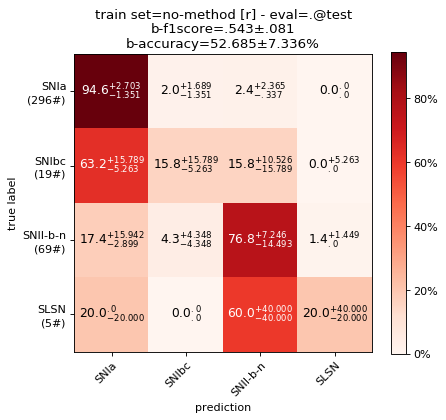

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0381
[2#] SPM_gamma_r=.0355
[3#] SPM_t0_r=.0342
[4#] LinearTrend_g=.0335
[5#] LinearTrend_r=.0300
[6#] SPM_gamma_g=.0252
[7#] SPM_tau_rise_r=.0240
[8#] ExcessVar_r=.0231
[9#] Meanvariance_r=.0230
[10#] SPM_tau_fall_r=.0217
(50, 4, 4)


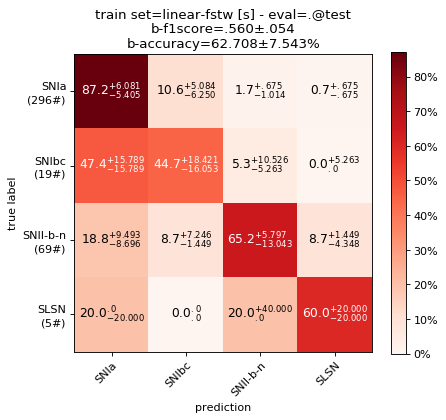

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0504
[2#] SPM_t0_r=.0415
[3#] LinearTrend_g=.0367
[4#] LinearTrend_r=.0303
[5#] SPM_gamma_r=.0283
[6#] SPM_tau_rise_r=.0276
[7#] Meanvariance_r=.0234
[8#] ExcessVar_r=.0221
[9#] SPM_tau_fall_g=.0210
[10#] SPM_tau_fall_r=.0208
(50, 4, 4)


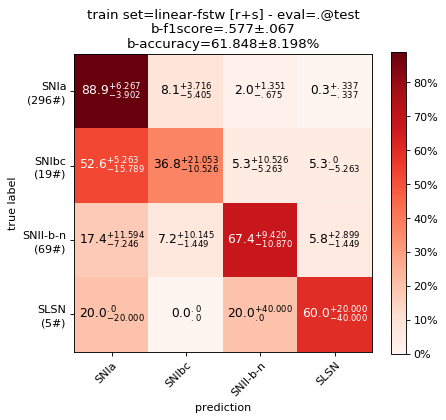

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0491
[2#] SPM_t0_r=.0379
[3#] LinearTrend_g=.0359
[4#] LinearTrend_r=.0332
[5#] SPM_gamma_r=.0313
[6#] Meanvariance_r=.0245
[7#] SPM_tau_rise_r=.0244
[8#] SPM_tau_fall_g=.0233
[9#] ExcessVar_r=.0227
[10#] SPM_gamma_g=.0212
==============================bspline-fstw
(50, 4, 4)


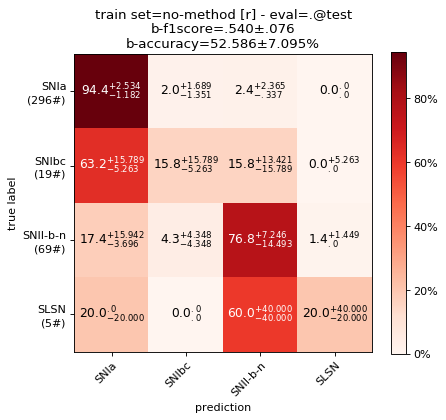

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0420
[2#] SPM_gamma_r=.0363
[3#] SPM_t0_r=.0340
[4#] LinearTrend_g=.0324
[5#] LinearTrend_r=.0294
[6#] SPM_tau_rise_r=.0254
[7#] ExcessVar_r=.0237
[8#] SPM_gamma_g=.0234
[9#] Meanvariance_r=.0227
[10#] SPM_tau_fall_g=.0207
(50, 4, 4)


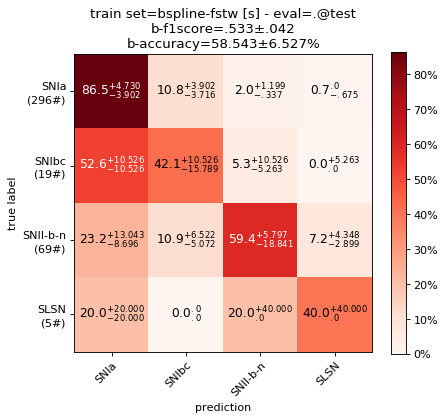

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0432
[2#] LinearTrend_g=.0417
[3#] SPM_t0_r=.0347
[4#] LinearTrend_r=.0338
[5#] SPM_gamma_r=.0307
[6#] SPM_tau_rise_r=.0270
[7#] SPM_gamma_g=.0262
[8#] Meanvariance_r=.0224
[9#] ExcessVar_r=.0213
[10#] CAR_tau_r=.0178
(50, 4, 4)


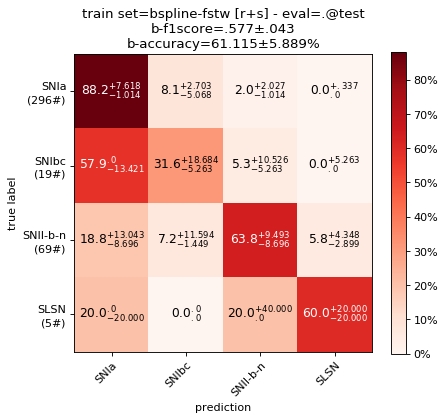

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0444
[2#] LinearTrend_g=.0431
[3#] SPM_t0_r=.0354
[4#] LinearTrend_r=.0347
[5#] SPM_gamma_r=.0321
[6#] SPM_gamma_g=.0253
[7#] Meanvariance_r=.0248
[8#] SPM_tau_rise_r=.0239
[9#] ExcessVar_r=.0233
[10#] SPM_tau_fall_g=.0201
==============================spm-mle-fstw
(50, 4, 4)


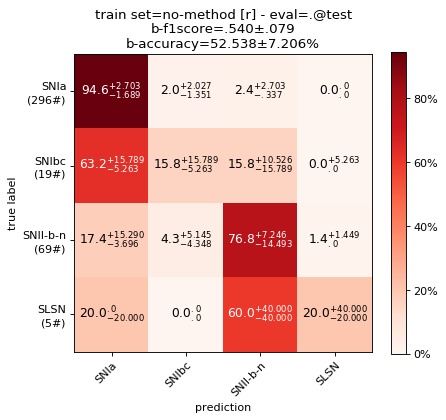

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0417
[2#] SPM_t0_r=.0336
[3#] LinearTrend_g=.0326
[4#] SPM_gamma_r=.0324
[5#] LinearTrend_r=.0290
[6#] SPM_tau_rise_r=.0254
[7#] Meanvariance_r=.0246
[8#] SPM_gamma_g=.0229
[9#] ExcessVar_r=.0226
[10#] SPM_tau_fall_g=.0226
(50, 4, 4)


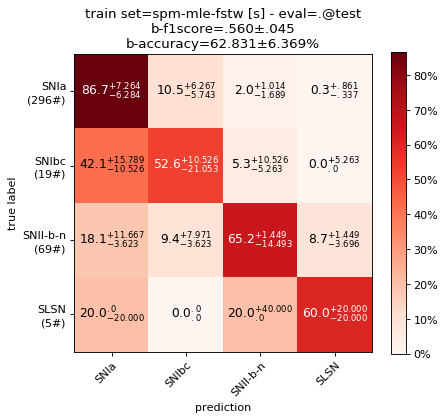

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0535
[2#] SPM_t0_r=.0395
[3#] LinearTrend_g=.0346
[4#] SPM_gamma_r=.0339
[5#] LinearTrend_r=.0320
[6#] PairSlopeTrend_g=.0256
[7#] SPM_tau_rise_r=.0255
[8#] Meanvariance_r=.0228
[9#] SPM_gamma_g=.0220
[10#] ExcessVar_r=.0211
(50, 4, 4)


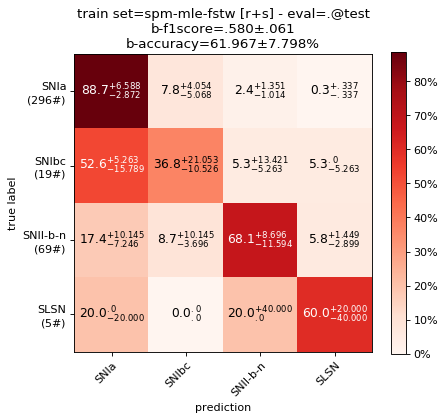

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0494
[2#] SPM_t0_r=.0393
[3#] LinearTrend_g=.0358
[4#] SPM_gamma_r=.0339
[5#] LinearTrend_r=.0329
[6#] SPM_tau_rise_r=.0249
[7#] SPM_gamma_g=.0248
[8#] Meanvariance_r=.0235
[9#] SPM_tau_fall_g=.0218
[10#] ExcessVar_r=.0213
==============================spm-mcmc-fstw
(50, 4, 4)


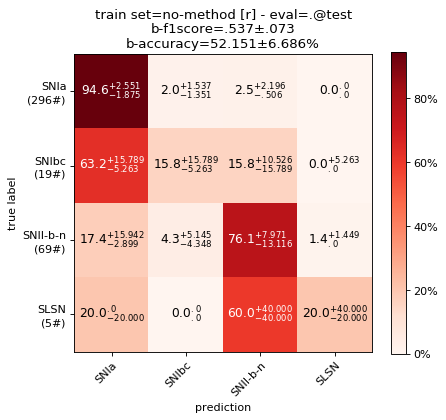

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0389
[2#] SPM_gamma_r=.0374
[3#] SPM_t0_r=.0338
[4#] LinearTrend_g=.0330
[5#] LinearTrend_r=.0294
[6#] Meanvariance_r=.0235
[7#] SPM_gamma_g=.0233
[8#] SPM_tau_rise_r=.0230
[9#] ExcessVar_r=.0221
[10#] SPM_beta_r=.0218
(50, 4, 4)


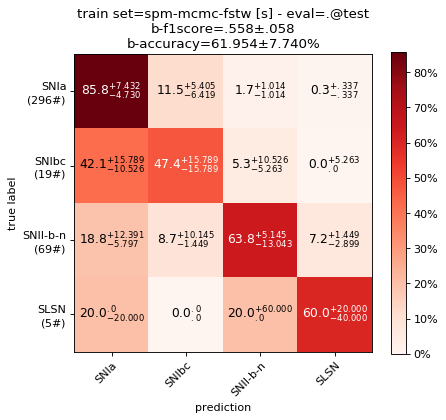

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0502
[2#] SPM_t0_r=.0413
[3#] LinearTrend_g=.0403
[4#] SPM_gamma_r=.0340
[5#] LinearTrend_r=.0324
[6#] SPM_tau_rise_r=.0252
[7#] PairSlopeTrend_g=.0226
[8#] SPM_tau_fall_r=.0213
[9#] SPM_gamma_g=.0213
[10#] Meanvariance_r=.0210
(50, 4, 4)


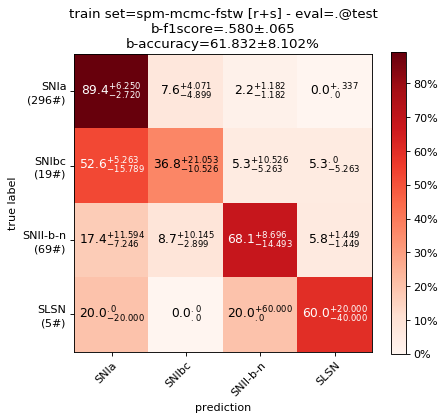

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0474
[2#] LinearTrend_g=.0395
[3#] SPM_t0_r=.0378
[4#] SPM_gamma_r=.0331
[5#] LinearTrend_r=.0321
[6#] SPM_tau_rise_r=.0261
[7#] Meanvariance_r=.0237
[8#] SPM_tau_fall_g=.0227
[9#] SPM_gamma_g=.0224
[10#] ExcessVar_r=.0218
==============================spm-mle-estw
(50, 4, 4)


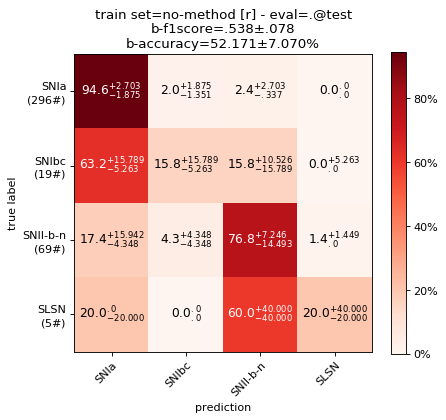

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0412
[2#] SPM_t0_r=.0337
[3#] LinearTrend_g=.0327
[4#] SPM_gamma_r=.0318
[5#] LinearTrend_r=.0312
[6#] SPM_gamma_g=.0245
[7#] Meanvariance_r=.0245
[8#] SPM_tau_rise_r=.0241
[9#] ExcessVar_r=.0233
[10#] SPM_tau_fall_g=.0220
(50, 4, 4)


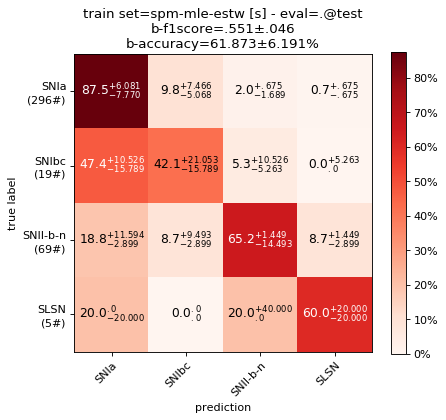

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0509
[2#] SPM_t0_r=.0342
[3#] LinearTrend_r=.0340
[4#] SPM_gamma_r=.0321
[5#] LinearTrend_g=.0320
[6#] PairSlopeTrend_g=.0234
[7#] Meanvariance_r=.0226
[8#] SPM_gamma_g=.0219
[9#] SPM_tau_fall_r=.0218
[10#] SPM_tau_rise_r=.0215
(50, 4, 4)


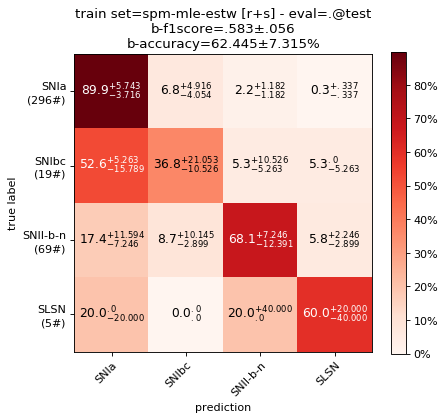

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0498
[2#] SPM_t0_r=.0352
[3#] SPM_gamma_r=.0350
[4#] LinearTrend_g=.0339
[5#] LinearTrend_r=.0336
[6#] SPM_tau_rise_r=.0236
[7#] Meanvariance_r=.0233
[8#] SPM_gamma_g=.0221
[9#] SPM_tau_fall_g=.0221
[10#] ExcessVar_r=.0219
==============================spm-mcmc-estw
(50, 4, 4)


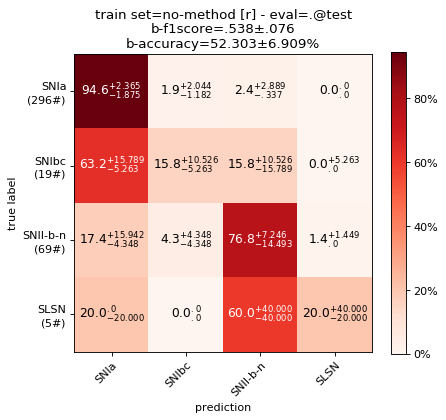

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0395
[2#] LinearTrend_g=.0358
[3#] SPM_gamma_r=.0340
[4#] SPM_t0_r=.0314
[5#] LinearTrend_r=.0298
[6#] SPM_tau_rise_r=.0247
[7#] SPM_gamma_g=.0237
[8#] Meanvariance_r=.0230
[9#] ExcessVar_r=.0227
[10#] SPM_tau_fall_g=.0220
(50, 4, 4)


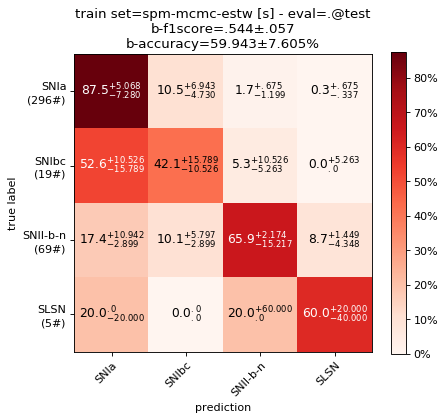

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0480
[2#] SPM_t0_r=.0368
[3#] SPM_gamma_r=.0340
[4#] LinearTrend_g=.0332
[5#] LinearTrend_r=.0302
[6#] SPM_tau_rise_r=.0264
[7#] SPM_gamma_g=.0246
[8#] PairSlopeTrend_g=.0237
[9#] Meanvariance_r=.0221
[10#] SPM_tau_fall_r=.0218
(50, 4, 4)


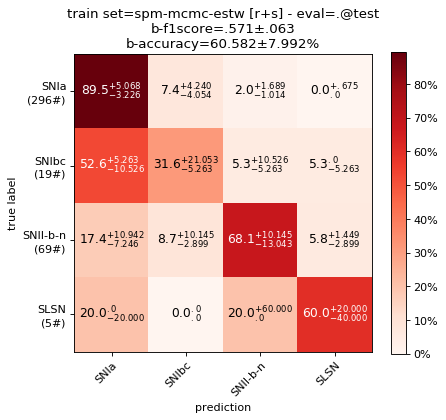

['SLSN', 'SNII-b-n', 'SNIa', 'SNIbc']
features:
[1#] SPM_t0_g=.0482
[2#] SPM_t0_r=.0366
[3#] LinearTrend_g=.0345
[4#] SPM_gamma_r=.0333
[5#] LinearTrend_r=.0290
[6#] SPM_tau_rise_r=.0269
[7#] SPM_gamma_g=.0253
[8#] Meanvariance_r=.0221
[9#] SPM_tau_fall_g=.0219
[10#] SPM_tau_fall_r=.0214


In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

mode = 'all' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    'spm-mle-fstw',
    'spm-mcmc-fstw',
    'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test' # val test
kf = '.'

for method in methods:
    print('='*30+method)
    #for train_config in ['r', 's']:
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall']*100 for f in files])
        print(cms.shape)

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train set={_title} - eval={kf}@{eval_lcset_name}'+'\n'
        title += f'b-f1score={bf1score_xe}'+'\n'
        title += f'b-accuracy={brecall_xe}%'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #print(files[0]()['features'])
        plt.show()
        print(class_names)
        print(files[0]()['rank'])
        df = files[0]()['wrongs_df']
        #display(df[df['_y']==0])
        #display(df[df['_y']==2])

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-recall':{'k':100, 'mn':f'b-accuracy'},
    f'b-f1score':{'k':1, 'mn':None},
    f'b-prauc':{'k':1, 'mn':None},
    f'b-rocauc':{'k':1, 'mn':None},
    f'b-xentropy':{'k':1, 'mn':None},
    }
info_df = DFBuilder()
for metric in dmetrics.keys():
    for train_config in ['r', 's', 'r+s']:
    #for train_config in ['r', 's']:
        d = {}
        for method in methods:
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[method] = metric_xe
            #print(len(metric_xe))
        
        mn = dmetrics[metric]['mn']
        info_df.append(f'metric={metric if mn is None else mn} [{train_config}]', d)
        
latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
print('% \multicolumn{3}{c|}{}')
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
metric & linear-fstw & bspline-fstw & spm-mle-fstw & spm-mcmc-fstw & spm-mle-estw & spm-mcmc-estw \srule\\\hline\hline
b-accuracy [r] & 52.685$\pm$7.336 & 52.586$\pm$7.095 & 52.538$\pm$7.206 & 52.151$\pm$6.686 & 52.171$\pm$7.070 & 52.303$\pm$6.909  \srule\\
b-accuracy [s] & 62.708$\pm$7.543 & 58.543$\pm$6.527 & 62.831$\pm$6.369 & 61.954$\pm$7.740 & 61.873$\pm$6.191 & 59.943$\pm$7.605  \srule\\
b-accuracy [r+s] & 61.848$\pm$8.198 & 61.115$\pm$5.889 & 61.967$\pm$7.798 & 61.832$\pm$8.102 & 62.445$\pm$7.315 & 60.582$\pm$7.992  \srule\\
\hline
b-f1score [r] & .543$\pm$.081 & .540$\pm$.076 & .540$\pm$.079 & .537$\pm$.073 & .538$\pm$.078 & .538$\pm$.07

,linear-fstw,bspline-fstw,spm-mle-fstw,spm-mcmc-fstw,spm-mle-estw,spm-mcmc-estw
metric=b-accuracy [r],52.685±7.336,52.586±7.095,52.538±7.206,52.151±6.686,52.171±7.070,52.303±6.909
metric=b-accuracy [s],62.708±7.543,58.543±6.527,62.831±6.369,61.954±7.740,61.873±6.191,59.943±7.605
metric=b-accuracy [r+s],61.848±8.198,61.115±5.889,61.967±7.798,61.832±8.102,62.445±7.315,60.582±7.992
metric=b-f1score [r],.543±.081,.540±.076,.540±.079,.537±.073,.538±.078,.538±.076
metric=b-f1score [s],.560±.054,.533±.042,.560±.045,.558±.058,.551±.046,.544±.057
metric=b-f1score [r+s],.577±.067,.577±.043,.580±.061,.580±.065,.583±.056,.571±.063
metric=b-prauc [r],.593±.067,.592±.065,.590±.064,.591±.064,.591±.064,.591±.067
metric=b-prauc [s],.590±.072,.562±.059,.592±.081,.593±.084,.595±.082,.595±.073
metric=b-prauc [r+s],.600±.079,.593±.071,.602±.079,.602±.080,.604±.077,.602±.076
metric=b-rocauc [r],.874±.031,.874±.031,.873±.031,.874±.030,.874±.030,.874±.031


In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        rank = files[0]()['rank']
        #print(rank)
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.3f}%)'

    info_df.append(f'rank={k+1}', d)

latex_kwargs = {
    'caption':f'eval-set={kf}@{eval_lcset_name}',
    'label':'?',
    'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
    #'hline_k':2,
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{eval-set=.@test}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc|cc}
\hline
rank & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mle-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mle-estw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (4.916\%) & SPM-t0-g (4.445\%) & SPM-t0-g (4.943\%) & SPM-t0-g (4.748\%) & SPM-t0-g (4.988\%) & SPM-t0-g (4.825\%)  \srule\\
2 & SPM-t0-r (3.798\%) & LinearTrend-g (4.314\%) & SPM-t0-r (3.936\%) & LinearTrend-g (3.951\%) & SPM-t0-r (3.524\%) & SPM-t0-r (3.670\%)  \srule\\
3 & LinearTrend-g (3.591\%) & SPM-t0-r (3.542\%) & LinearTrend-g (3.588\%) & SPM-t0-r (3.783\%) & SPM-gamma-r (3.502\%) & LinearTrend-g (3.457\%)  \srule\\
4 & LinearTrend-r (3.323\%) & LinearTrend-r (3.480\%) & SP

,linear-fstw [r+s],bspline-fstw [r+s],spm-mle-fstw [r+s],spm-mcmc-fstw [r+s],spm-mle-estw [r+s],spm-mcmc-estw [r+s]
rank=1,SPM-t0-g (4.916%),SPM-t0-g (4.445%),SPM-t0-g (4.943%),SPM-t0-g (4.748%),SPM-t0-g (4.988%),SPM-t0-g (4.825%)
rank=2,SPM-t0-r (3.798%),LinearTrend-g (4.314%),SPM-t0-r (3.936%),LinearTrend-g (3.951%),SPM-t0-r (3.524%),SPM-t0-r (3.670%)
rank=3,LinearTrend-g (3.591%),SPM-t0-r (3.542%),LinearTrend-g (3.588%),SPM-t0-r (3.783%),SPM-gamma-r (3.502%),LinearTrend-g (3.457%)
rank=4,LinearTrend-r (3.323%),LinearTrend-r (3.480%),SPM-gamma-r (3.392%),SPM-gamma-r (3.320%),LinearTrend-g (3.399%),SPM-gamma-r (3.334%)
rank=5,SPM-gamma-r (3.135%),SPM-gamma-r (3.212%),LinearTrend-r (3.293%),LinearTrend-r (3.217%),LinearTrend-r (3.367%),LinearTrend-r (2.906%)
rank=6,Meanvariance-r (2.458%),SPM-gamma-g (2.537%),SPM-tau-rise-r (2.491%),SPM-tau-rise-r (2.613%),SPM-tau-rise-r (2.365%),SPM-tau-rise-r (2.691%)
rank=7,SPM-tau-rise-r (2.444%),Meanvariance-r (2.487%),SPM-gamma-g (2.490%),Meanvariance-r (2.372%),Meanvariance-r (2.332%),SPM-gamma-g (2.534%)
rank=8,SPM-tau-fall-g (2.331%),SPM-tau-rise-r (2.391%),Meanvariance-r (2.355%),SPM-tau-fall-g (2.279%),SPM-gamma-g (2.212%),Meanvariance-r (2.219%)
rank=9,ExcessVar-r (2.279%),ExcessVar-r (2.337%),SPM-tau-fall-g (2.183%),SPM-gamma-g (2.247%),SPM-tau-fall-g (2.212%),SPM-tau-fall-g (2.197%)
rank=10,SPM-gamma-g (2.125%),SPM-tau-fall-g (2.019%),ExcessVar-r (2.139%),ExcessVar-r (2.187%),ExcessVar-r (2.193%),SPM-tau-fall-r (2.146%)
